# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset, ValDataset, TripletDataset
from countryguess.training import TripletModel, triplet_mining, eval_fn

## Plotting datasets

### Initialise datasets

In [5]:
ref_data = Dataset()
train_data = TripletDataset()
val_data = ValDataset()
test_data = TestDataset()

### Plotting

#### Training data

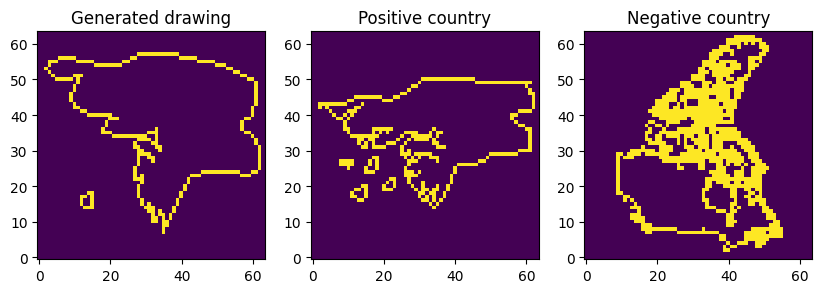

In [6]:
idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]

#Plotting
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title("Generated drawing") 
axs[1].imshow(sample["pos_img"], interpolation='nearest', origin='lower')
axs[1].set_title("Positive country") 
axs[2].imshow(sample["neg_img"], interpolation='nearest', origin='lower')
axs[2].set_title("Negative country") 
plt.show()

#### Validation set

In [31]:
from countryguess.utils import poly_to_img

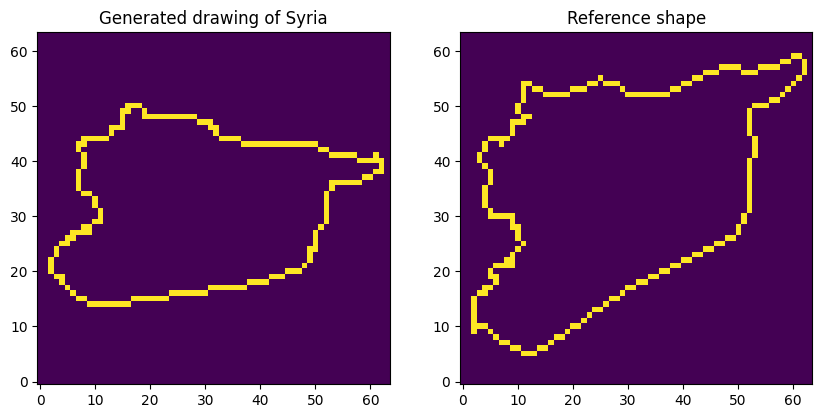

In [51]:
idx = random.randint(0, len(val_data) - 1)
sample = val_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"Generated drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

#### Test set (user drawings)

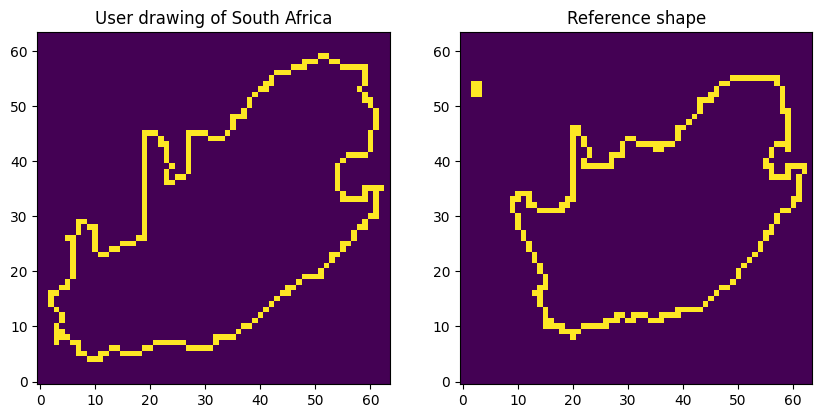

In [63]:
idx = random.randint(0, len(test_data) - 1)
sample = test_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"User drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

## Training model

Run the following command to start the MLFlow Tracking UI: `mlflow ui --port 5001`
<br>Access the MLFlow Tracking UI at: http://127.0.0.1:5001

In [2]:
device = torch.device("cpu")

In [6]:
mlflow.set_experiment("docker")

params = {"channels": 4*random.randint(1, 6),
          "nr_conv_blocks": random.randint(2, 5),
          "embedding_size": 32*random.randint(2, 7),
          "shape": 32*random.randint(2, 5),
          "learning_rate": random.uniform(0.006, 0.012), 
          "margin": random.uniform(0.5, 1.5),
          "temperature": random.uniform(0.5, 1),
          "nr_epochs": random.randint(40, 100)}
print(params)

model = TripletModel(**params).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
triplet_loss = nn.TripletMarginLoss(margin=params['margin'])

{'channels': 4, 'nr_conv_blocks': 2, 'embedding_size': 128, 'shape': 96, 'learning_rate': 0.011144173037371556, 'margin': 1.396893474724743, 'temperature': 0.5010603430591514, 'nr_epochs': 47}


In [7]:
#Initialise datasets
ref_data = Dataset(shape=(params["shape"], params["shape"]))
train_data = TripletDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])
val_data = ValDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])

train_dl = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_data, batch_size=32, num_workers=2)

In [8]:
with mlflow.start_run() as run:
    mlflow.log_params(params)
    
    #Start training
    for epoch in range(params['nr_epochs']):
        losses = []        
        model.train()
        for batch in train_dl:
            optimizer.zero_grad()
            anc_emb = model(batch['drawing'][:, None, :, :].type(torch.float32).to(device))
            pos_emb = model(batch['pos_img'][:, None, :, :].type(torch.float32).to(device))
            neg_emb = model(batch['neg_img'][:, None, :, :].type(torch.float32).to(device))
    
            #Mine triplets
            anc_emb, pos_emb, neg_emb = triplet_mining(anc_emb, pos_emb, neg_emb, 
                                                       batch["pos_idx"], batch["neg_idx"])
    
            loss = triplet_loss(anc_emb, pos_emb, neg_emb)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
    
        mlflow.log_metric("loss", np.mean(losses), epoch)
        
        print('Epoch: {}/{}\t loss: {:.3f}'.format(epoch+1, params['nr_epochs'], np.mean(losses)))
    
        if (epoch+1)%5==0:
            ranking = np.array([])
            model.eval()
            model.load_reference(ref_data)
            for batch in val_dl:
                rank = eval_fn(model, batch)
                ranking = np.append(ranking, rank)
    
            mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
            mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
            mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)
    
            print('Epoch: {}/{}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
                  .format(epoch+1, params['nr_epochs'], np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1)))

Epoch: 1/47	 loss: 0.236
Epoch: 2/47	 loss: 0.163
Epoch: 3/47	 loss: 0.081
Epoch: 4/47	 loss: 0.079
Epoch: 5/47	 loss: 0.050
Epoch: 5/47	 Average rank: 3.44	 top 10 acc: 94.9%	 top 1 acc: 61.9%	
Epoch: 6/47	 loss: 0.045
Epoch: 7/47	 loss: 0.062
Epoch: 8/47	 loss: 0.054
Epoch: 9/47	 loss: 0.143
Epoch: 10/47	 loss: 0.055
Epoch: 10/47	 Average rank: 3.04	 top 10 acc: 93.4%	 top 1 acc: 75.1%	
Epoch: 11/47	 loss: 0.034
Epoch: 12/47	 loss: 0.030
Epoch: 13/47	 loss: 0.023
Epoch: 14/47	 loss: 0.099
Epoch: 15/47	 loss: 0.105
Epoch: 15/47	 Average rank: 2.82	 top 10 acc: 95.4%	 top 1 acc: 75.1%	
Epoch: 16/47	 loss: 0.032
Epoch: 17/47	 loss: 0.021
Epoch: 18/47	 loss: 0.063
Epoch: 19/47	 loss: 0.076
Epoch: 20/47	 loss: 0.028
Epoch: 20/47	 Average rank: 2.36	 top 10 acc: 97.0%	 top 1 acc: 74.6%	
Epoch: 21/47	 loss: 0.023
Epoch: 22/47	 loss: 0.020
Epoch: 23/47	 loss: 0.045
Epoch: 24/47	 loss: 0.039
Epoch: 25/47	 loss: 0.008
Epoch: 25/47	 Average rank: 2.19	 top 10 acc: 97.0%	 top 1 acc: 77.2%	
Epoch

### Evaluate model

In [9]:
test_data = TestDataset(shape=(params["shape"], params["shape"]))
test_dl = DataLoader(test_data, batch_size=32)

In [10]:
ranking = np.array([])
model.load_reference(ref_data)
model.eval()
country_names = []
for batch in test_dl:
    rank = eval_fn(model, batch)
    ranking = np.append(ranking, rank)
    country_names.extend(batch['country_name'])
    
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric("nr_test_samples", len(test_data))
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [11]:
print('Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
      .format(np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1))) 

Average rank: 3.81	 top 10 acc: 96.9%	 top 1 acc: 68.8%	


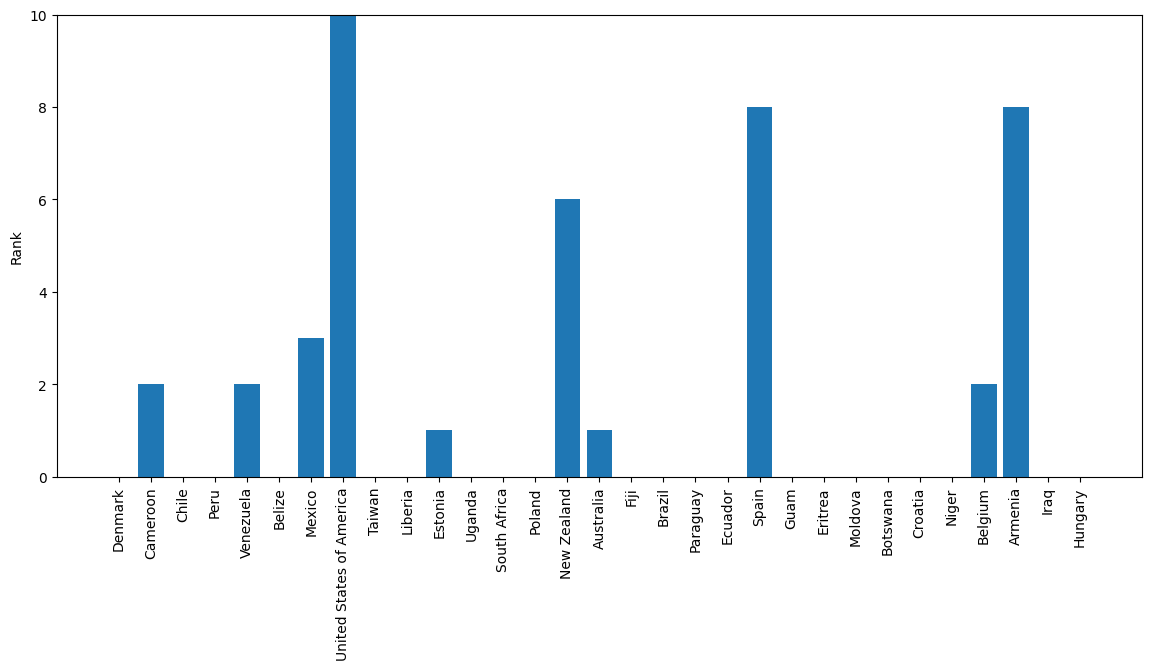

In [12]:
fig = plt.figure(figsize = (14, 6))
plt.bar(country_names, ranking)
plt.xticks(rotation=90)
plt.ylim((0, 10))
plt.ylabel("Rank")
plt.show()

### Log model

In [13]:
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.pytorch.log_model(model, "model")

## Register model
Compare models and push to producton

In [108]:
#For now use the UI

In [138]:
best_run = mlflow.search_runs(order_by=["metrics.test_avg_rank ASC"]).iloc[0]
mlflow.register_model(f"runs:/{best_run.run_id}/model", "Model")

Registered model 'Model' already exists. Creating a new version of this model...
Created version '2' of model 'Model'.


<ModelVersion: aliases=[], creation_timestamp=1714761765025, current_stage='None', description=None, last_updated_timestamp=1714761765025, name='Model', run_id='e6e9ca159b304b7ab1224f65240f6d5b', run_link=None, source='file:///Users/jortdejong/GitHub/country-guess/mlruns/0/e6e9ca159b304b7ab1224f65240f6d5b/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>